# Многоклассовая классификация

Для чего нужен этот ноутбук:
* Построить первую модель многоклассовой классификации
* Выбрать метрики для оценки модели многоклассовой классификации

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split

np.random.seed(21)
random_state = 147
DATA_FOLDER = "data/"

## Download & Split Data

In [2]:
df_images = pd.read_csv('https://raw.githubusercontent.com/Amlaith/medical_diseases_recognition/refs/heads/main/some_data/data_DEC24_SVD_128comp_5000.csv').iloc[:, 1:]

In [3]:
X, y = df_images.drop(columns="class"), df_images["class"]

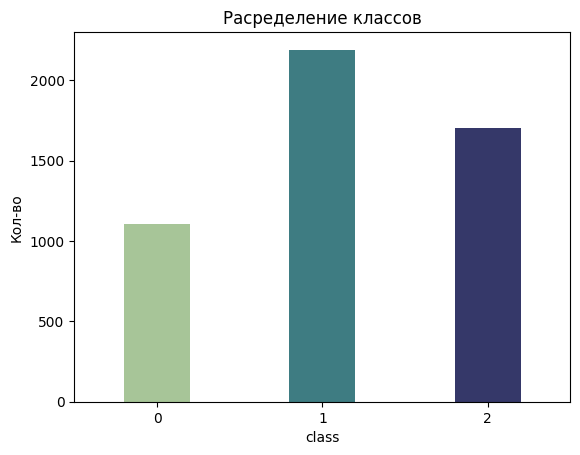

In [4]:
sns.countplot(x=y, hue=y, legend=False, palette='crest', width=0.4);
plt.title("Расределение классов")
plt.ylabel("Кол-во");

We have 3 classes:


|Label|Text Label|Desc|Has Bounding Box|
|:-|:-|:-|:-|
|0|Lung Opacity|Есть затемнение в лёгких, есть bounding box|Yes|
|1|No Lung Opacity / Not Normal|Нет затемнения в лёгких, нет bounding box, но есть патология|No|
|2|Normal|Здоровые лёгкие|No|

Наблюдается дисбаланс классов.

В нашей задаче наиболее распространён класс: болен, но не пневмонией. 

In [5]:
y.value_counts(sort=False, normalize=True)

class
2    0.3408
1    0.4382
0    0.2210
Name: proportion, dtype: float64

In [6]:
# Отложенная выборка
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

In [7]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def get_fast_metrics(y_pred, y_true, freq_class=1) -> None:

    f1 = np.round(f1_score(y_pred, y_true, average="weighted"), 8)

    freq = np.round(np.sum(y_true == freq_class)/y_true.shape[0], 8)
    win_norm = np.round((f1 - freq) / (1 - freq), 8)

    print(f"F1-score: {f1}")
    print(f"Freq class: {freq}")
    print(f"Win-norm: {win_norm}")


def get_gini(y_pred, y_true) -> None: 
    y_true_binarized = label_binarize(y_test, classes=[0, 1, 2])
    y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2])

    # Расчет ROC-AUC для многоклассовой задачи
    auc_score = roc_auc_score(y_true_binarized, y_pred_binarized,
                            multi_class='ovr', average=None)

    roc_auc_metric = y.value_counts(sort=False, normalize=True) @ auc_score[::-1]
    gini = 2 * roc_auc_metric - 1
    print("gini: ", np.round(gini, 4))

## Базовый SVM Linear

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [9]:
scl = MinMaxScaler().fit(X_train)

X_train = scl.transform(X_train)
X_test = scl.transform(X_test)

In [10]:
LinearSVC = SVC(kernel = 'linear', random_state=random_state, max_iter=-1, tol=1e-3)

LinearSVC.fit(X_train, y_train)

y_pred = LinearSVC.predict(X_test)
get_fast_metrics(y_pred, y_test)
get_gini(y_pred, y_test)

F1-score: 0.60199248
Freq class: 0.42266667
Win-norm: 0.31061053
gini:  0.3432


## Построим модель с нелинейным ядром

In [11]:
NonLinearSVC = SVC(kernel = 'rbf', random_state=random_state)

NonLinearSVC.fit(X_train, y_train)

y_pred = NonLinearSVC.predict(X_test)
get_fast_metrics(y_pred, y_test)
get_gini(y_pred, y_test)

F1-score: 0.64071781
Freq class: 0.42266667
Win-norm: 0.37768673
gini:  0.3987


## **Метрики**

In [12]:
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Дополнительные размышления про confusion_matrix
В многоклассовом случае, она оказывается более полезной

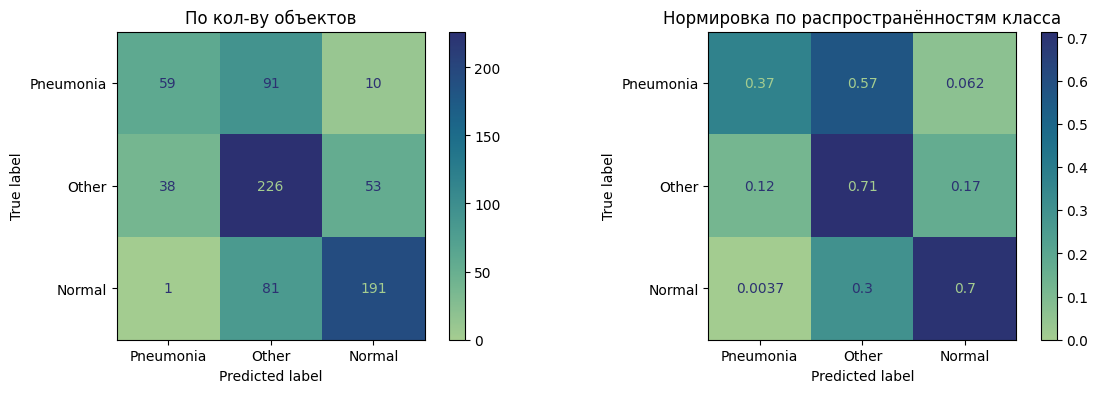

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

labels = ["Pneumonia", "Other", "Normal"]

ax[0].set_title("По кол-ву объектов")
ax[1].set_title("Нормировка по распространённостям класса")

disp_1 = ConfusionMatrixDisplay.from_estimator(NonLinearSVC, X_test, y_test, display_labels=labels, cmap="crest", ax=ax[0])
disp_1.im_.set_clim(0)
disp_2 = ConfusionMatrixDisplay.from_estimator(NonLinearSVC, X_test, y_test, display_labels=labels, cmap="crest", normalize="true", ax=ax[1]);
disp_2.im_.set_clim(0)

Какие **выводы можно сделать** по матрице ошибок | confusion matrix:
1. Какие классы модель путает больше, а какие почти не путает
* Текущая модель хорошо различает 0 и 2 классы, но путает 0 и 1
2. Можно примерно оценить качество классификации
* Текущая модель: 
    * относительно хорошо предсказывает 2 класс (healthy), 
    * плоховато 1 класс (not healthy, put not pheumonia), 
    * и совесем плохо 0 (lung opacity + has bb)
3. Эта метрика визуальна и относительно проста в интерпретации